In [1]:
# import system libs
import os
import time
import shutil

import pathlib
import itertools

from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from PIL import Image
import tensorflow.keras as K
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import Model
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow.keras as K
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D 
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications.xception import Xception
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
!unzip /gdrive/MyDrive/dataset/crd2.zip > /dev/null

In [4]:
train_folder = "/content/crd2/train"
test_folder = "/content/crd2/test"
val_folder="/content/crd2/val"

In [5]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
 
count_files(os.path.join(val_folder))


There are 50 files in OSCC
There are 21 files in Normal


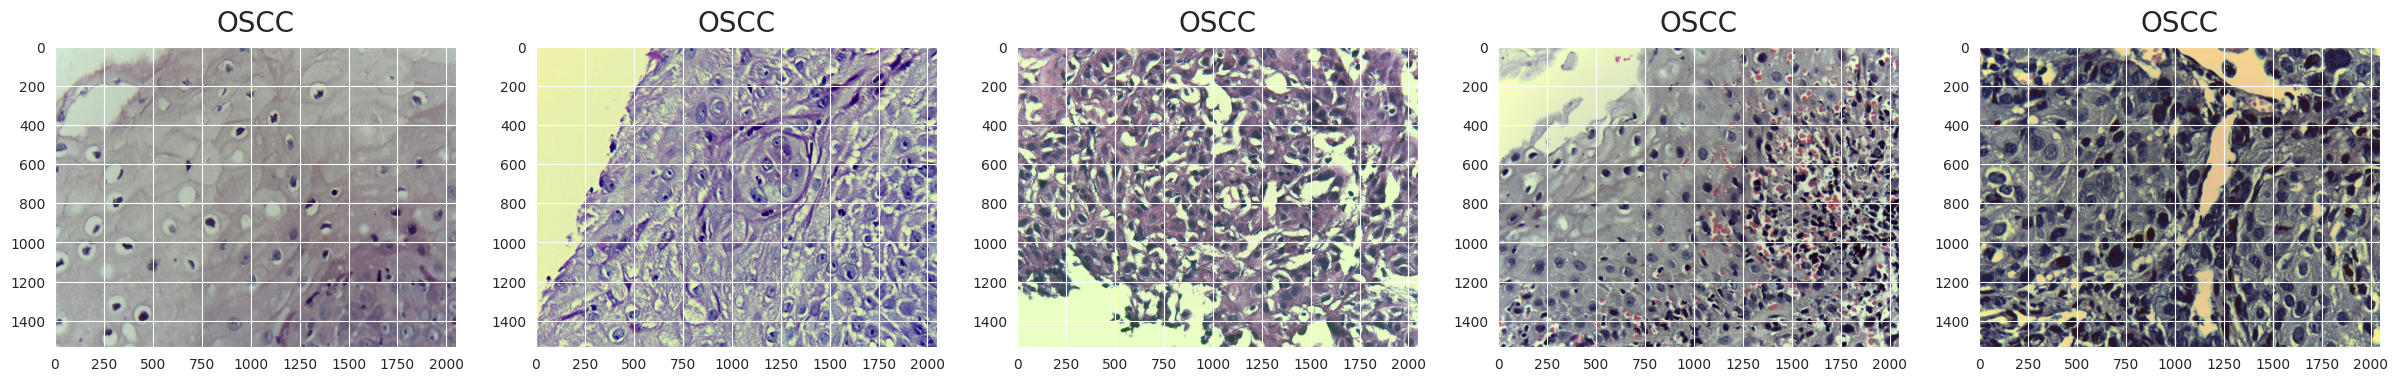

In [6]:
select_plant="OSCC"
rows,columns = 1,5

display_folder=os.path.join(train_folder,select_plant)
total_images=rows*columns
fig=plt.figure(1, figsize=(30, 10))

for i,j in enumerate(os.listdir(display_folder)):      
    
    img = plt.imread(os.path.join(train_folder,select_plant,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_plant, pad = 11, size=20)
    plt.imshow(img)
    
    if i==total_images-1:
        break

In [7]:
n_cat =2

batch_size = 48
batch_size_predict = 64
input_shape = (299,299)


In [8]:
x_model = Xception(input_shape=list(input_shape) + [3], 
                   weights='imagenet', 
                   include_top=False)

83683744/83683744 [==============================] - 3s 0us/step


In [9]:
gm_exp = tf.Variable(3., dtype=tf.float32)
def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                           axis=[1,2], 
                           keepdims=False)+1.e-8)**(1./gm_exp)
    return pool

In [10]:
X_feat = Input(x_model.output_shape[1:])

lambda_layer = Lambda(generalized_mean_pool_2d)
lambda_layer.trainable_weights.extend([gm_exp])
X = lambda_layer(X_feat)
X = Dropout(0.05)(X)
X = Activation('relu')(X)
X = Dense(n_cat, activation='softmax')(X)

top_model = Model(inputs=X_feat, outputs=X)
top_model.summary()

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 10, 2048)]    0         
                                                                 
 lambda (Lambda)             (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 activation (Activation)     (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________________________________


In [11]:
X_image = Input(list(input_shape) + [3])

X_f = x_model(X_image)
X_f = top_model(X_f)

model = Model(inputs=X_image, outputs=X_f)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 model (Functional)          (None, 2)                 4098      
                                                                 
Total params: 20,865,578
Trainable params: 20,811,050
Non-trainable params: 54,528
_________________________________________________________________


In [12]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
# Checkpoint to save best model per epoch
model_filepath = "/gdrive/MyDrive/dataset//model-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [14]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (299, 299),
    batch_size = 48,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (299, 299),
    batch_size = 48, 
    class_mode = 'categorical')

Found 4536 images belonging to 2 classes.
Found 694 images belonging to 2 classes.


In [15]:
class_map = training_set.class_indices
class_map

{'Normal': 0, 'OSCC': 1}

In [16]:
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  callbacks=[checkpoint],
  validation_steps=len(test_set)
)

Epoch 1/30
95/95 [==============================] - ETA: 0s - loss: 0.3059 - accuracy: 0.8686
Epoch 1: val_accuracy improved from -inf to 0.77954, saving model to /gdrive/MyDrive/dataset/model-01-0.7795.hdf5
95/95 [==============================] - 397s 4s/step - loss: 0.3059 - accuracy: 0.8686 - val_loss: 1.0189 - val_accuracy: 0.7795
Epoch 2/30
95/95 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.9387
Epoch 2: val_accuracy improved from 0.77954 to 0.80836, saving model to /gdrive/MyDrive/dataset/model-02-0.8084.hdf5
95/95 [==============================] - 335s 4s/step - loss: 0.1475 - accuracy: 0.9387 - val_loss: 1.0078 - val_accuracy: 0.8084
Epoch 3/30
95/95 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.9517
Epoch 3: val_accuracy improved from 0.80836 to 0.88905, saving model to /gdrive/MyDrive/dataset/model-03-0.8890.hdf5
95/95 [==============================] - 333s 3s/step - loss: 0.1239 - accuracy: 0.9517 - val_loss: 0.2997 - v

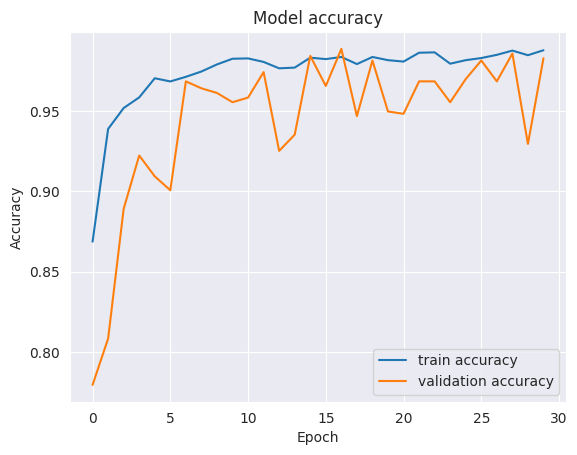

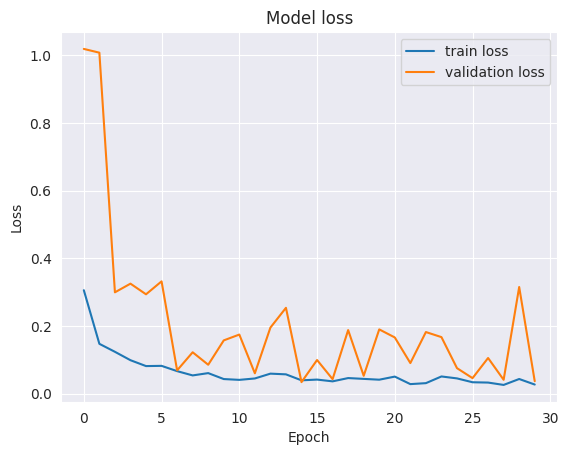

In [17]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_Xception')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_Xception')
    plt.show()
    
plot_accuracy(history)
plot_loss(history)

In [19]:

path_to_model='/gdrive/MyDrive/dataset/model-17-0.9885.hdf5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..


The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Done!


In [20]:
# Using the test dataset
score = model.evaluate_generator(test_set)
print('Test loss:', score[0])
print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Test loss: 0.04310093820095062

accuracy: 98.85%


In [21]:
validation_data_dir = '/content/crd2/val'

validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(299,299),
    batch_size=48,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]*100))

Found 71 images belonging to 2 classes.
Test Accuracy: 98.592


In [22]:
category={
    0:'Normal',1:'OSCC'
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(299, 299))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    prob = np.max(prediction)
    
    plt.title("Prediction - {} with Probability {:.2f}%".format(category[index],prob*100))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(299, 299))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        prob = np.max(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))


1/1 [==============================] - 3s 3s/step


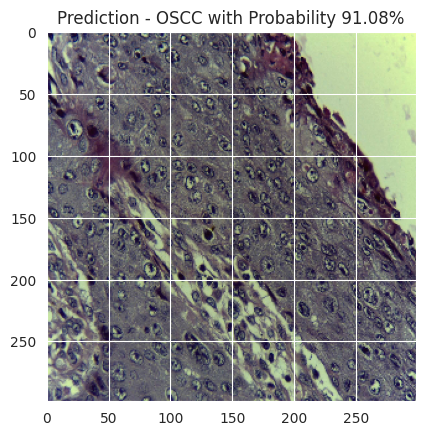

In [23]:
predict_image('/content/crd2/val/OSCC/OSCC_400x_182.jpg',model)

1/1 [==============================] - 0s 48ms/step


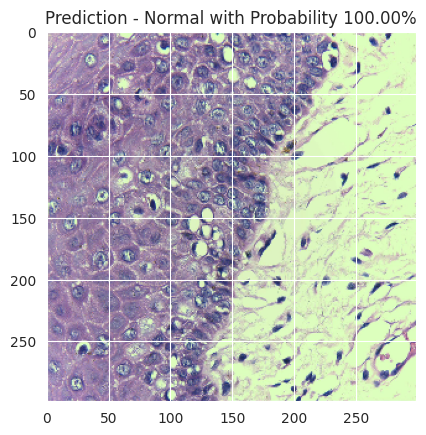

In [24]:
predict_image('/content/crd2/val/Normal/Normal_400x_158.jpg',model)

In [25]:
def labels_confusion_matrix(val_folder):
    
    folder_path=val_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(299,299))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 2
    cmap="OrRd"
    cm_plot_labels = [i for i in range(2)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

1/1 [==============================] - 0s 40ms/step


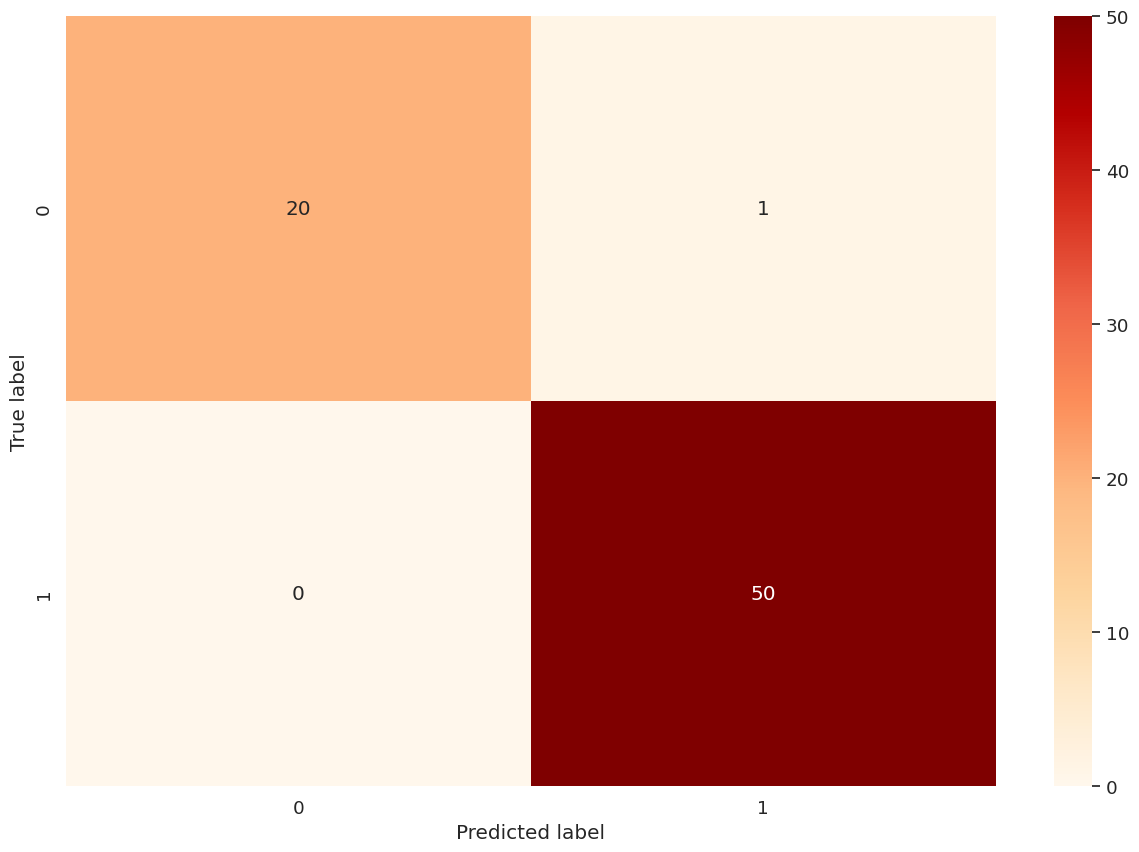

In [26]:
y_true,y_pred=labels_confusion_matrix(validation_data_dir)
print_confusion_matrix(y_true,y_pred)

In [27]:
from sklearn.metrics import confusion_matrix,classification_report
y_true,y_pred=labels_confusion_matrix(validation_data_dir)
print(classification_report(y_true, y_pred))

1/1 [==============================] - 0s 24ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.98      1.00      0.99        50

    accuracy                           0.99        71
   macro avg       0.99      0.98      0.98        71
weighted avg       0.99      0.99      0.99        71

